# How to use the simple GAN (Generative Adversarial Network) in PyTorch

In [25]:
# Core Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

# Data Handling & Preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Visualization & Debugging
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation
The dataset I'm using is UNSW-NB15, the data already split so I don't need to split it manually. The dataset is divided into:
1. Training-set with CSV format.
2. Testing-set with CSV format.

Load the Dataset

In [26]:
# Load CSV files
df_train = pd.read_csv('UNSW_NB15_training-set.csv')
df_test = pd.read_csv('UNSW_NB15_testing-set.csv')

# Display the first 5 rows
df_train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


Check class distribution and answer this question:
1. What are the minority attack classes?
2. How severe is the imbalance?

In [27]:
# Check column names
print(df_train.columns)

# Count occurences of each unieque value in the attack_cat column
print(df_train["attack_cat"].value_counts())

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')
attack_cat
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64


In [28]:
# Drop rows where 'attack_cat' is 'Normal'
df_train_attack = df_train[df_train['attack_cat'] != 'Normal']

# Count occurences of each attack classes
print(df_train_attack["attack_cat"].value_counts())

attack_cat
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: count, dtype: int64


Visualize the Class Imbalance

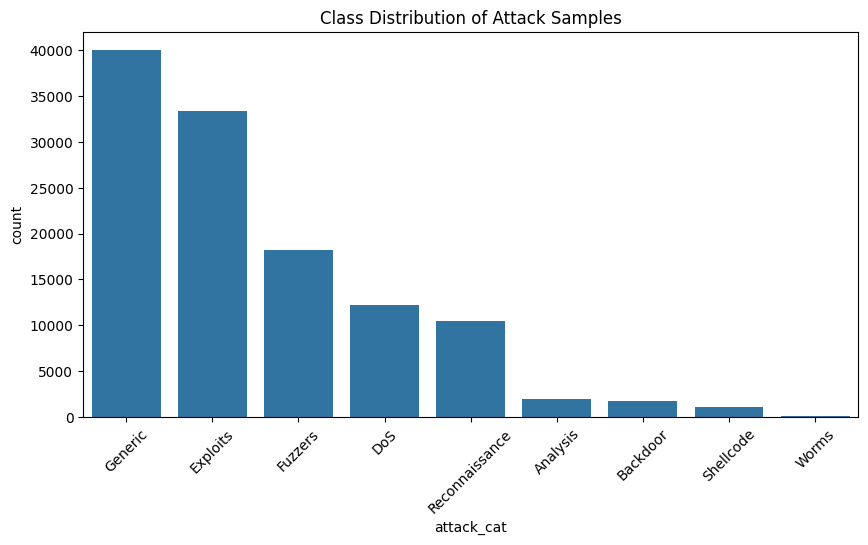

In [29]:
plt.figure(figsize=(10, 5))
sns.countplot(x=df_train_attack['attack_cat'], order=df_train_attack['attack_cat'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Class Distribution of Attack Samples')
plt.show()

To measure how severe the imbalance is, I'm use imbalance ratio (IR) and other statistical metrics.
The imbalance ratio (IR) tells us how imbalanced the dataset is. It’s calculated as:

IR = Majority class count / Minority class count

If IR > 1.5, the dataset is imbalanced.  
If IR > 10, the imbalance is severe.  
If any class has less than 5% of the dataset, which indicates a significant imbalance.

In [30]:
# Find the majority and minority class sizes
class_counts = df_train_attack['attack_cat'].value_counts()
majority_class = class_counts.max()
minority_class = class_counts.min()

# Compute imbalance ratio
imbalance_ratio = majority_class / minority_class
print(f"Imbalance Ratio (IR): {imbalance_ratio:.2f}\n")

# Compute percentage distribution
total_samples = len(df_train_attack)
percentages = (class_counts / total_samples) * 100
print(percentages)

Imbalance Ratio (IR): 307.69

attack_cat
Generic           33.517400
Exploits          27.981163
Fuzzers           15.237010
DoS               10.276435
Reconnaissance     8.790776
Analysis           1.675870
Backdoor           1.463034
Shellcode          0.949380
Worms              0.108932
Name: count, dtype: float64


The answer above question is:
1. There is few minority attack classes **less then 5%** of the dataset here: Worms, Shellcode, Backdoor, and Analysis.
2. The Imbalance Ratio is 307.69 which indicate the dataset is **highly imbalance!**.

Extract Minority Classes  
I'm focus on attack types below **5%** (Analysis, Backdoor, Shellcode, Worms)

In [31]:
# Define the minority classes
minority_classes = ['Analysis', 'Backdoor', 'Shellcode', 'Worms']

# Extract samples of minority classes
minority_df = df_train_attack[df_train_attack['attack_cat'].isin(minority_classes)]
print(minority_df['attack_cat'].value_counts())

attack_cat
Analysis     2000
Backdoor     1746
Shellcode    1133
Worms         130
Name: count, dtype: int64


Normalize Features  
GANs work best when features are scaled between **0 and 1**

In [32]:
# Select only numerical features
numerical_cols = df_train_attack.select_dtypes(include=['float64', 'int64']).columns

# Apply MinMaxScalar to normalize the numerical features
scaler = MinMaxScaler()
df_train_attack[numerical_cols] = scaler.fit_transform(df_train_attack[numerical_cols])

# Drop the label column
df_train_attack.drop(columns=['id', 'label', 'service', 'state'], inplace=True)

# Display the first 5 rows
df_train_attack.head()

C:\Users\Rajasa\AppData\Local\Temp\ipykernel_12212\36885542.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_attack[numerical_cols] = scaler.fit_transform(df_train_attack[numerical_cols])
C:\Users\Rajasa\AppData\Local\Temp\ipykernel_12212\36885542.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_attack.drop(columns=['id', 'label', 'service', 'state'], inplace=True)


,dur,proto,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
47911,1.500024e-07,ddp,0.000104,0.0,0.000011,0.0,0.111111,0.996078,0.0,0.014845,...,0.00,0.000000,0.046875,0.0,0.0,0.0,0.016949,0.058824,0.0,Backdoor
47912,1.500024e-07,ipv6-frag,0.000104,0.0,0.000011,0.0,0.111111,0.996078,0.0,0.014845,...,0.02,0.033333,0.093750,0.0,0.0,0.0,0.016949,0.117647,0.0,Backdoor
47913,1.500024e-07,cftp,0.000104,0.0,0.000011,0.0,0.111111,0.996078,0.0,0.014845,...,0.00,0.000000,0.078125,0.0,0.0,0.0,0.000000,0.098039,0.0,Backdoor
47914,5.000080e-08,wsn,0.000104,0.0,0.000011,0.0,0.333333,0.996078,0.0,0.044534,...,0.02,0.033333,0.093750,0.0,0.0,0.0,0.016949,0.098039,0.0,Backdoor
47915,1.333355e-07,pvp,0.000104,0.0,0.000011,0.0,0.125000,0.996078,0.0,0.016700,...,0.00,0.000000,0.046875,0.0,0.0,0.0,0.169492,0.058824,0.0,Backdoor


## Define the GAN Architecture

GAN Architecture Overview  
A GAN consist of two networks:
1. **Generator (G)** --> Takes random noise and generates fake attack samples.
2. **Discriminator (D)** --> Determine if a sample is real or fake.

Define the Generator  
The generator takes **random noise** as input and outputs a synthetic attack sample.

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128), # Fully connected layer
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim), # Output the same number of features as the dataset
            nn.Tanh() # Output values between -1 and 1
        )
    
    def forward(self, z):
        return self.model(z)

**input_dim** --> Size of the random noise (e.g., 100).  
**output_dim** --> Number of features in your dataset.

Define the Discriminator  
The discriminator classifies data as **real (1)** or **fake (0)**.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2), 
            nn.Linear(128, 1), 
            nn.Sigmoid() # Output probability of being real
        )
    
    def forward(self, x):
        return self.model(x)

Uses **LeakyReLU** to avoid dead neurons.  
Ends with **Sigmoid** to output probability.

Initialize Models & Optimizers

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define dimensions
input_dim = 100 # Random noise size
output_dim = len(numerical_cols) # Number of features in dataset

# Initialize models
generator = Generator(input_dim, output_dim)
discriminator = Discriminator(output_dim)

# Optimizers & Loss Functions
lr = 0.0002 # Learning rate
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)
criterion = nn.BCELoss() # Binary Cross-Entropy loss

**criterion** helps measure how well the discriminator differentiates real vs. fake.  
**Adam optimizer** helps in faster convergence.

## Training the GAN

**Training Process:**
1. The **generator** tries to fool the discriminator.
2. The **discriminator** improves by correctly classifying real vs. fake samples.
3. Over time, the generator creates more realistic attack samples.

In [ ]:
# Convert real data into tensor format
real_data = torch.tensor(minority_df[numerical_cols].values, dtype=torch.float32)

# Training parameters
num_epochs = 10000
batch_size = 64

for epoch in range(num_epochs):
    ### Step 1: Train Discriminator ###
    optimizer_D.zero_grad()

    # Real samples
    real_labels = torch.ones(real_data.shape[0], 1) # Real data labels = 1
    real_output = discriminator(real_data)
    loss_real = criterion(real_output, real_labels)

    # Fake samples
    noise = torch.randn(real_data.shape[0], input_dim) # Generate noise
    fake_data = generator(noise) # Generate synthetic attack samples
    fake_labels = torch.zeros(real_data.shape[0], 1) # Fake data labels = 0
    fake_output = discriminator(fake_data.detach()) # Detach so Generator doesn't update
    loss_fake = criterion(fake_output, fake_labels)

    # Total Discriminator loss
    loss_D = loss_real + loss_fake
    loss_D.backward()
    optimizer_D.step()

    ### Step 2: Train Generator ###
    optimizer_G.zero_grad()

    # Generate fake samples
    fake_output = discriminator(fake_data)
    loss_G = criterion(fake_output, torch.ones(real_data.shape[0], 1)) # Want to fool Discriminator

    loss_G.backward()
    optimizer_G.step()

    # Print every 1000 epochs
    if epoch % 1000 == 0:
        print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

**Step 1**: Train the **discriminator** on real and fake data.  
**Step 2**: Train the **generator** to fool the discriminator.
Runs for **10,000 epochs**

## Generate Synthetic Attack Samples

Generate New Attack Samples  
After training, use the generator to create synthetic attack data.

In [ ]:
# Generate 500 synthetic attack samples
num_samples = 500
noise = torch.randn(num_samples, input_dim)
synthetic_data = generator(noise).detach().numpy()

# Convert back to original scale
synthetic_data = scaler.inverse_transform(synthetic_data)

# Create a DataFrame for the new samples
synthetic_df = pd.DataFrame(synthetic_data, columns=numerical_cols)
synthetic_df['attack_cat'] = 'Synthetic_Worms' # Label as synthetic samples

# Save to CSV
synthetic_df.to_csv('Synthetic_attack_data.csv', index=False)
print("Synthetic attack samples saved!")

## Evaluate and Validate